In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.arima.model import ARIMA

C:\Users\dsant\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dsant\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\dsant\AppData\Local\Temp\ipykernel_27476\4075577839.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
!pip install scipy


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install pmdarima


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from pmdarima.arima import auto_arima

In [5]:
df = pd.read_excel('temperature.xlsx', index_col="Date", parse_dates=True)
df.head()

,Daily minimum temperatures
Date,
1981-01-01 00:00:00,20.7
1981-02-01 00:00:00,17.9
1981-03-01 00:00:00,18.8
1981-04-01 00:00:00,14.6
1981-05-01 00:00:00,15.8


In [6]:
df.shape


(3647, 1)

In [7]:
df.describe()

,Daily minimum temperatures
count,3647.000000
mean,11.186647
std,4.061671
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [8]:
# Renomeando a coluna
df = df.rename(columns={"Daily minimum temperatures": "MinTemp"})

In [9]:
df.dtypes

MinTemp    float64
dtype: object

In [10]:
df.sort_index(inplace=True)

### seasonal decomposition

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 800x600 with 0 Axes>

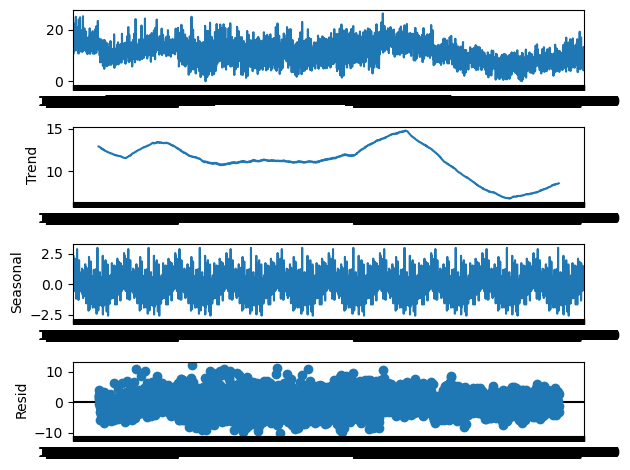

In [12]:
result = seasonal_decompose(df, model ="add", period=365)


fig = plt.figure(figsize=(8,6))
fig = result.plot()

#### data (graph) above confirm a seasonality

### stationarity test

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
result = adfuller(df["MinTemp"].dropna())
print(f"ADF Test:{result[0]}")
print(f"p value:{result[1]}")

# se p value > 5% is not a stationary trend

ADF Test:-3.1926511703941163
p value:0.0204140185237133


#### The serie above is not stationary

In [15]:
result = adfuller(df["MinTemp"].diff().dropna())
print(f"ADF Test:{result[0]}")
print(f"p value:{result[1]}")

ADF Test:-17.889481928311028
p value:2.981417989268415e-30


In [16]:
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, 
                       max_p=3, max_q=3, seasonal=True,
                       m=6, D=1, start_P=1, start_Q=1,
                       max_P=2, max_Q=2, 
                       information_criterions="aic", 
                       trace=True, 
                       error_action="ignore", 
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=18647.626, Time=1.60 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=23045.187, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=20675.953, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=1.37 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=1.76 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=2.13 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=inf, Time=6.30 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=4.16 sec
 ARIMA(1,1,1)(0,1,0)[6]             : AIC=22618.290, Time=0.25 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=inf, Time=2.38 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=5.76 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=8.15 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=18692.755, Time=0.92 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=0.87 sec
 ARIMA(2,1,1)(1,1,1)[6]             : AIC=18643.687, Time=3.44 sec
 ARIMA

### test the model

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [19]:
model = SARIMAX(df, order=(2,1,1), seasonal_order=(1,1,1,6))

result_sarimax = model.fit()

C:\Users\dsant\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dsant\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [20]:
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           MinTemp   No. Observations:                 3647
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -9315.843
Date:                           Mon, 19 Feb 2024   AIC                          18643.687
Time:                                   15:28:18   BIC                          18680.885
Sample:                                        0   HQIC                         18656.936
                                          - 3647                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1580      0.018      8.672      0.000       0.122       0.194
ar.L2          0.0453      0.018      2.586      0.010       0.011       0.080
ma.L1         -0.9599      0.006   -172.972      0.000      -0.971      -0.949
ar.S.L6       -0.3020      0.017    -17.918      0.000      -0.335      -0.269
ma.S.L6       -0.9404      0.006   -156.527      0.000      -0.952      -0.929
sigma2         9.7253      0.213     45.561      0.000       9.307      10.144
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.06
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### predictions

In [33]:
predictions = result_sarimax.get_prediction(start= -12)
mean_prediction = predictions.predicted_mean

In [34]:
# Confidence Interval
confidence_interval = predictions.conf_int()
down_limit = confidence_interval.iloc[:,0]
up_limit = confidence_interval.iloc[:,1]

down_limit[0], up_limit[0] 

C:\Users\dsant\AppData\Local\Temp\ipykernel_27476\2476646932.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down_limit[0], up_limit[0]


(3.8408513029801066, 16.06529728353646)

In [35]:
mean_prediction[0]

C:\Users\dsant\AppData\Local\Temp\ipykernel_27476\1650964497.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_prediction[0]


9.953074293258283

In [36]:
datas_preview = np.asarray(mean_prediction.index)
datas = np.asarray(df.index)

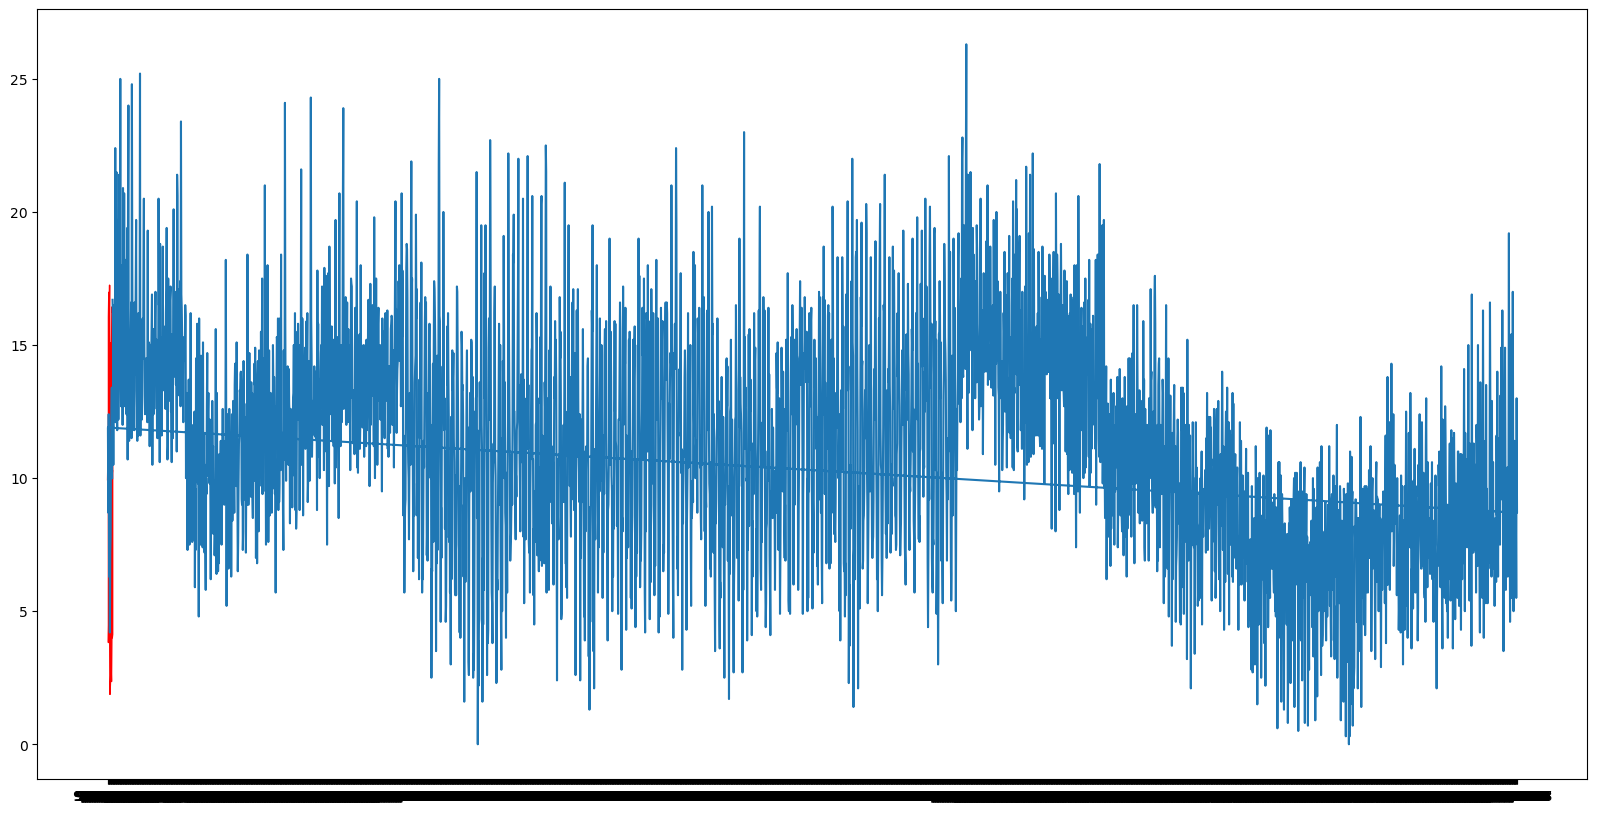

In [37]:
plt.figure(figsize=(20,10))
plt.plot(datas_preview, mean_prediction.values, color = "red", label="prediction")
plt.fill_between(datas_preview, down_limit, up_limit, color = "red")
plt.plot(datas, df.values, label="real")
plt.show()

### mean square error

In [42]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [43]:
mae = mean_absolute_error(df[-12:].values, mean_prediction.values)
print(mae)

2.3519785164977187


In [44]:
from math import sqrt

In [46]:
rmse = sqrt(mean_squared_error(df[-12:].values, mean_prediction))
print(rmse)

2.646063821122123


### Forecast

In [47]:
forecast = result_sarimax.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
mean_forecast.size

C:\Users\dsant\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


12

In [49]:
confidence_interval_forecast = forecast.conf_int()
down_limit_f = confidence_interval_forecast.iloc[:,0]
up_limit_f = confidence_interval_forecast.iloc[:,1]

down_limit_f[10:], up_limit_f[10:] 

(3657    3.912678
 3658    2.161721
 Name: lower MinTemp, dtype: float64,
 3657    16.750868
 3658    15.008196
 Name: upper MinTemp, dtype: float64)

In [52]:
mean_forecast[:10]

3647    11.149647
3648    10.075634
3649     9.771239
3650     8.653460
3651     8.944633
3652     7.911427
3653     9.788502
3654     9.381081
3655    10.228417
3656     9.823075
Name: predicted_mean, dtype: float64

In [53]:
datas_forecast = np.asarray(mean_forecast.index)
pred_datas = np.asarray(mean_prediction.index)

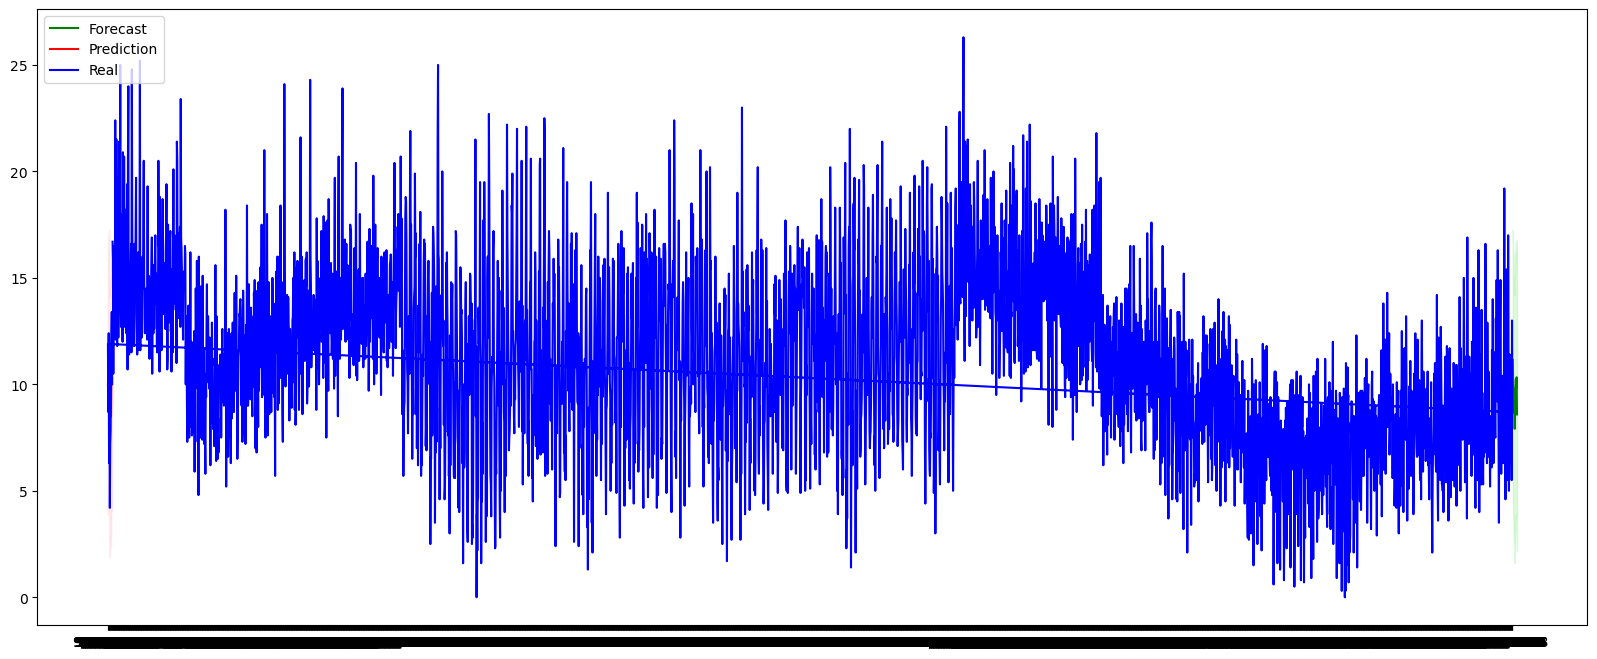

In [55]:
dates = np.asarray(df.index)

plt.figure(figsize=(20, 8
                   ))

# Plotting forecast
plt.plot(datas_forecast, mean_forecast.values, color="green", label="Forecast")
plt.fill_between(datas_forecast, down_limit_f, up_limit_f, color="lightgreen", alpha=0.3)

# Plotting prediction
plt.plot(datas_preview, mean_prediction.values, color="red", label="Prediction")
plt.fill_between(datas_preview, down_limit, up_limit, color="pink", alpha=0.3)

# Plotting real data
plt.plot(dates, df["MinTemp"], color="blue", label="Real")

plt.legend(loc="upper left")
plt.show()